In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import random
import json
import statsmodels.graphics.tsaplots as tsaplots
import pymc as pm

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries.
import requests
from datetime import datetime
from dateutil import parser
from collections import Counter
from itertools import groupby

In [7]:
def getTopCriticReview(url):
    rotten = 0
    fresh = 0

    results_critics = []

    page=requests.get(url)
    soup = BeautifulSoup(page.text, "html.parser")


    page_reviews = soup.find("div", attrs={"class":"review_table"}).find_all("div", attrs={"class":"row review_table_row"})
    for review in page_reviews:
        bool_rotten = 0

        #Check if the review is rotten or fresh
        review_rotten = review.find_all("div", attrs ={"class":"review_icon icon small rotten"})
        if (len(review_rotten) is 0):
            fresh+=1
            bool_rotten = 1
        else:
            rotten+=1

        name = review.find("div", attrs ={"class":"col-sm-13 col-xs-24 col-sm-pull-4 critic_name"}).get_text() 

        review_date = review.find("div", attrs ={"class":"review_date subtle small"}).get_text() 
        dt = parser.parse(review_date).date()  #convert it into python datetime format
        #print dt, type(dt)

        results_critics.append((name,bool_rotten ))

    #pause for a while
    time.sleep(1)

#     print rotten
#     print fresh

    return results_critics

In [8]:
def getMovies(url): 

    movies = []
    for x in range(20):
        try:
            page=requests.get("http://www.rottentomatoes.com/critic/"+url+"/movies?cats=&genreid=&letter=&switches=&sortby=&limit=50&page="+str(x+1))
            soup = BeautifulSoup(page.text, "html.parser")
            tmp = soup.find_all("td", attrs = {"class":"center"})
            for m in tmp[0:50]:
                movies.append(m.find("a").get("href"))

        except Exception as e:
            print "Exception"
    
    #pause for a while
    time.sleep(1)

    return movies

In [13]:
critic1 = getMovies('kenneth-turan')
critic2 = getMovies('peter-howell')
critic3 = getMovies('joe-morgenstern')
critic4 = getMovies('ty-burr')
critic5 = getMovies('steven-rea')

In [33]:
len(set(critic3) & set(critic4) & set(critic5))

321

In [34]:
common_movies = (set(critic3) & set(critic4) & set(critic5))
with open('common_movies_multiple_confusion.json', 'w') as fp:
    json.dump(list(common_movies),fp)

In [35]:
with open('common_movies_multiple_confusion.json') as data_file: 
    common_movies = json.load(data_file)

In [3]:
# run this line
top_critics = [" Joe Morgenstern  Wall Street Journal "," Ty Burr  Boston Globe "," Steven Rea  Philadelphia Inquirer " ]
top_critics_rating = {}

In [37]:
i = 1
for m in common_movies:
    top_critics_rating[i] = getTopCriticReview("http://www.rottentomatoes.com/"+ m + "reviews/?type=top_critics")
    i += 1

In [40]:
with open('topcriticreview.json', 'w') as fp:
    json.dump(top_critics_rating,fp)

In [4]:
# run from here
with open('topcriticreview.json') as data_file: 
    top_critics_rating = json.load(data_file)

In [5]:
top_ratings = np.zeros((len(top_critics_rating),len(top_critics)))

In [6]:
i = 0
for key in top_critics_rating:
    j = 0
    for c in top_critics_rating[key]:
        if c[0] in top_critics:
            top_ratings[i,j] = c[1]
            j += 1
    i += 1

In [ ]:
num_movie = 150 # len(top_critics_rating)
num_top_critics = len(top_critics)
alpha = [1,1]
rho = pm.Dirichlet('rho',alpha) # generate the rho from dirichlet. note that only 1 value is output here

# generate the 150 labels with multinomial distribution
label = []
for k in range(num_movie):
    label.append(pm.Multinomial('label'+str(k), n=1, p=[rho[0],1-rho[0]])) # p = [P(fresh),P(rotten)]
labels = pm.Container(label)

lambda1 = [5,1]
lambda2 = [1,5]
confusion = pm.Container([pm.CompletedDirichlet('confusion_fresh1',pm.Dirichlet('confuse_fresh1',lambda1)),
                          pm.CompletedDirichlet('confusion_rotten1',pm.Dirichlet('confuse_rotten1',lambda2)),
                          pm.CompletedDirichlet('confusion_fresh2',pm.Dirichlet('confuse_fresh2',lambda1)),
                          pm.CompletedDirichlet('confusion_rotten2',pm.Dirichlet('confuse_rotten2',lambda2)),
                          pm.CompletedDirichlet('confusion_fresh3',pm.Dirichlet('confuse_fresh3',lambda1)),
                          pm.CompletedDirichlet('confusion_rotten3',pm.Dirichlet('confuse_rotten3',lambda2))])    

# create the likelihood
@pm.observed
def get_likelihood(value=top_ratings, all_confuse=confusion, z=labels):
    likelihood = 0
    # loop through every rating
    for i in range(num_movie):
        for j in range(num_top_critics):
            theta = all_confuse[j*2:j*2+2]
            if z[i][0] == 1: # if the label is fresh, choose the first row of the confusion matrix
                likelihood += pm.multinomial_like([value[i][j],1-value[i][j]],1,theta[0]) # add the log-probabilities
            else: # if the label is rotten, choose the second row of the confusion matrix
                likelihood += pm.multinomial_like([value[i][j],1-value[i][j]],1,theta[1])
    return likelihood

params = [rho, confusion,get_likelihood, labels] # include the parameters that need to be varied in the pymc run
model=pm.Model(params)
mcmc = pm.MCMC(model)
mcmc.sample(iter=10000, burn=2000,thin=2)

 [-----------------100%-----------------] 10001 of 10000 complete in 4336.7 sec

In [ ]:
plt.figure(figsize=[12,4]) 
plt.plot(rho.trace())
plt.ylabel("rho")
plt.xlabel('iterations')

In [ ]:
plt.figure(figsize=[14,5])
rho_hist = plt.hist(rho.trace(), bins=15, normed=True, label='rho')
plt.xlabel("rho")
plt.ylabel("count")

# find the MAP
map_index_rho = np.argmax(rho_hist[0]) #index of the largest value in the histogram
hist_bin_middle_rho = 0.5*rho_hist[1][:-1] + 0.5*rho_hist[1][1:] #value of the bin middle
rho_map = hist_bin_middle_rho[map_index_rho]
print "MAP for rho: ", rho_map

In [26]:
theta_fresh1 = [prob[0][0] for prob in confusion[0].trace()]
theta_rotten1 = [prob[0][1] for prob in confusion[1].trace()]
theta_fresh2 = [prob[0][0] for prob in confusion[2].trace()]
theta_rotten2 = [prob[0][1] for prob in confusion[3].trace()]
theta_fresh3 = [prob[0][0] for prob in confusion[4].trace()]
theta_rotten3 = [prob[0][1] for prob in confusion[5].trace()]

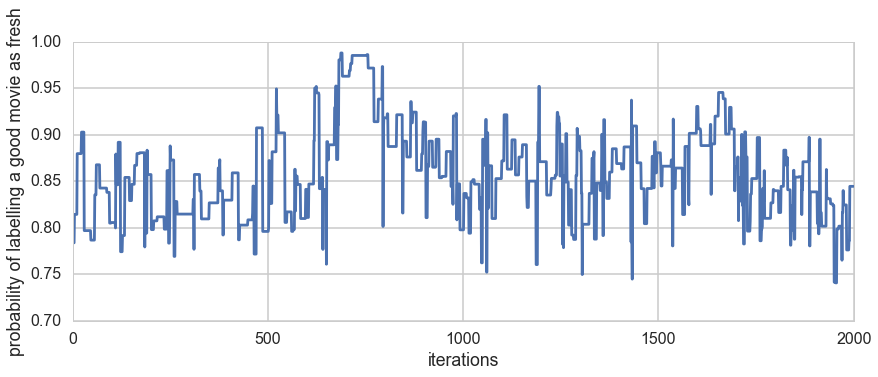

In [27]:
plt.figure(figsize=[14,5])
plt.plot(theta_fresh1)
plt.ylabel("probability of labelling a good movie as fresh")
plt.xlabel("iterations")

MAP for labelling a good movie as fresh:  0.847689664982


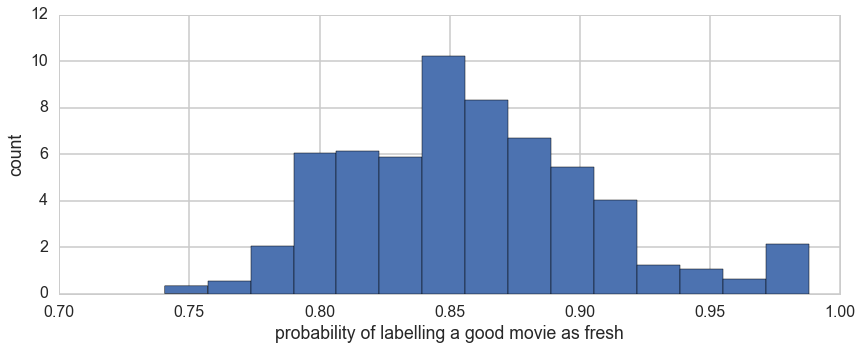

In [28]:
plt.figure(figsize=[14,5])
fresh_hist = plt.hist(theta_fresh1, bins=15, normed=True, label='confusion_fresh')
plt.xlabel("probability of labelling a good movie as fresh")
plt.ylabel("count")

# find the MAP
map_index_fresh = np.argmax(fresh_hist[0]) #index of the largest value in the histogram
hist_bin_middle_fresh = 0.5*fresh_hist[1][:-1] + 0.5*fresh_hist[1][1:] #value of the bin middle
fresh_map = hist_bin_middle_fresh[map_index_fresh]
print "MAP for labelling a good movie as fresh: ", fresh_map

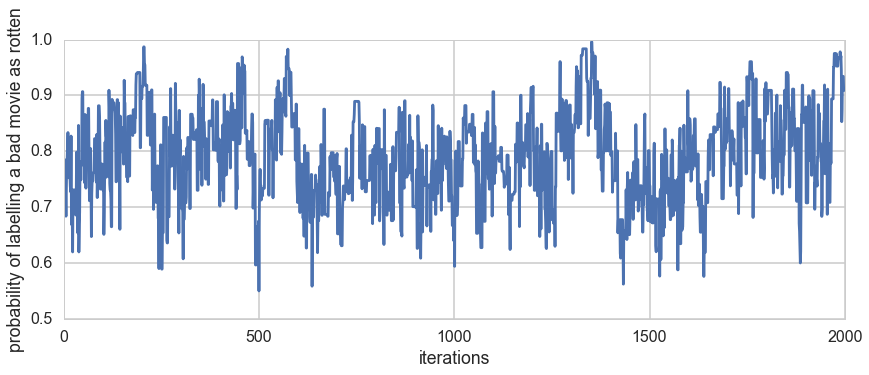

In [29]:
plt.figure(figsize=[14,5])
plt.plot(theta_rotten1)
plt.ylabel("probability of labelling a bad movie as rotten")
plt.xlabel("iterations")

MAP for labelling a bad movie as rotten:  0.802702845497


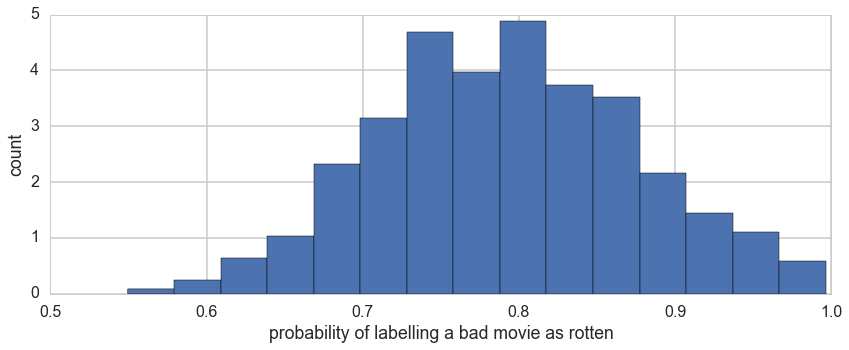

In [32]:
plt.figure(figsize=[14,5])
rotten_hist = plt.hist(theta_rotten1, bins=15, normed=True, label='confusion_rotten')
plt.xlabel("probability of labelling a bad movie as rotten")
plt.ylabel("count")

# find the MAP
map_index_rotten = np.argmax(rotten_hist[0]) #index of the largest value in the histogram
hist_bin_middle_rotten = 0.5*rotten_hist[1][:-1] + 0.5*rotten_hist[1][1:] #value of the bin middle
rotten_map = hist_bin_middle_rotten[map_index_rotten]
print "MAP for labelling a bad movie as rotten: ", rotten_map

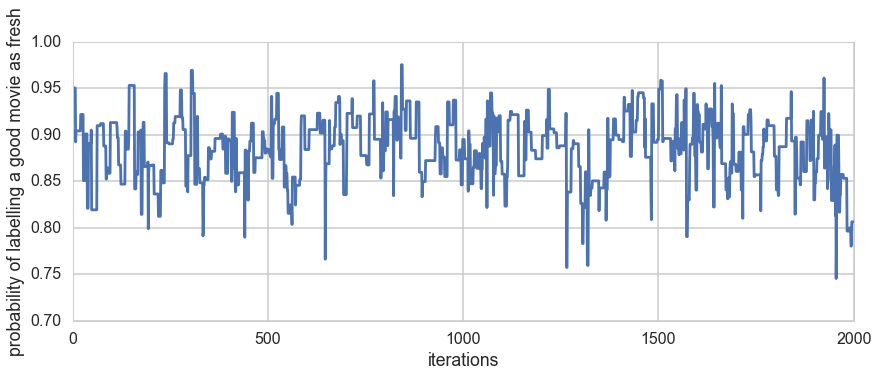

In [33]:
plt.figure(figsize=[14,5])
plt.plot(theta_fresh2)
plt.ylabel("probability of labelling a good movie as fresh")
plt.xlabel("iterations")

MAP for labelling a good movie as fresh:  0.890835496082


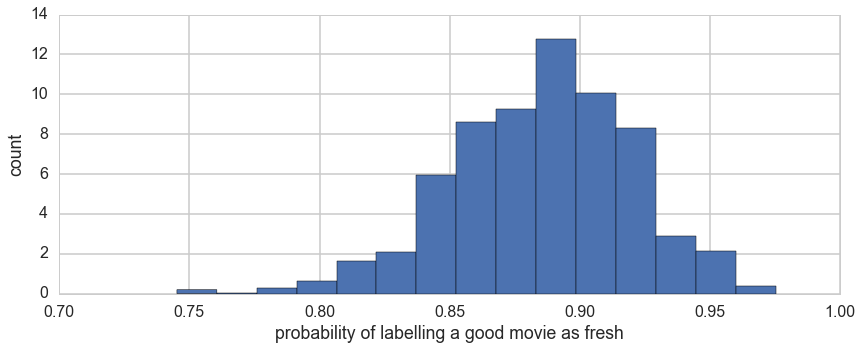

In [35]:
plt.figure(figsize=[14,5])
fresh_hist = plt.hist(theta_fresh2, bins=15, normed=True, label='confusion_fresh')
plt.xlabel("probability of labelling a good movie as fresh")
plt.ylabel("count")

# find the MAP
map_index_fresh = np.argmax(fresh_hist[0]) #index of the largest value in the histogram
hist_bin_middle_fresh = 0.5*fresh_hist[1][:-1] + 0.5*fresh_hist[1][1:] #value of the bin middle
fresh_map = hist_bin_middle_fresh[map_index_fresh]
print "MAP for labelling a good movie as fresh: ", fresh_map

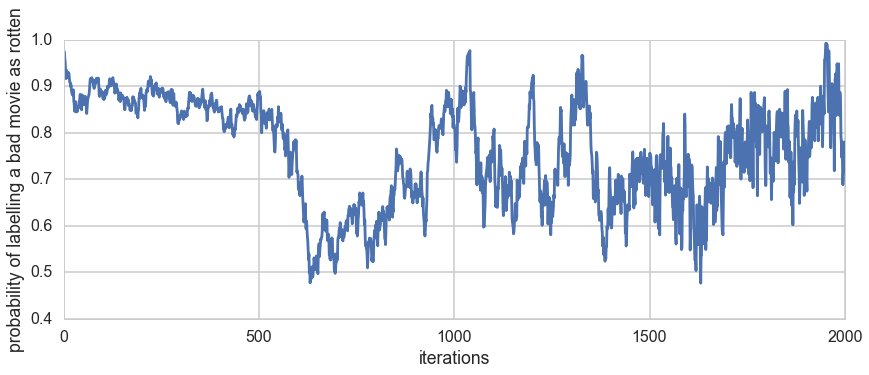

In [37]:
plt.figure(figsize=[14,5])
plt.plot(theta_rotten2)
plt.ylabel("probability of labelling a bad movie as rotten")
plt.xlabel("iterations")

MAP for labelling a bad movie as rotten:  0.871596985916


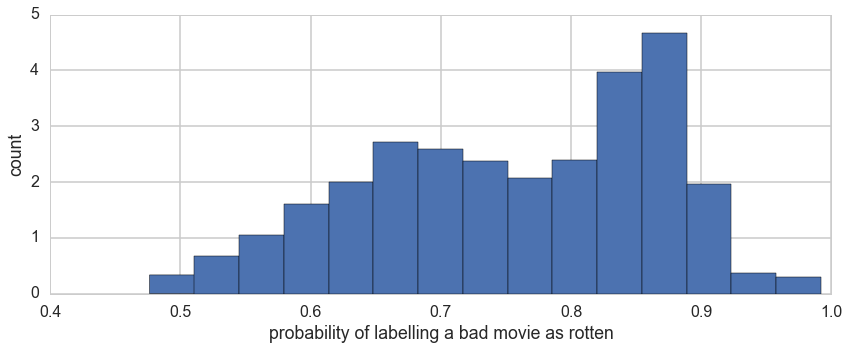

In [38]:
plt.figure(figsize=[14,5])
rotten_hist = plt.hist(theta_rotten2, bins=15, normed=True, label='confusion_rotten')
plt.xlabel("probability of labelling a bad movie as rotten")
plt.ylabel("count")

# find the MAP
map_index_rotten = np.argmax(rotten_hist[0]) #index of the largest value in the histogram
hist_bin_middle_rotten = 0.5*rotten_hist[1][:-1] + 0.5*rotten_hist[1][1:] #value of the bin middle
rotten_map = hist_bin_middle_rotten[map_index_rotten]
print "MAP for labelling a bad movie as rotten: ", rotten_map

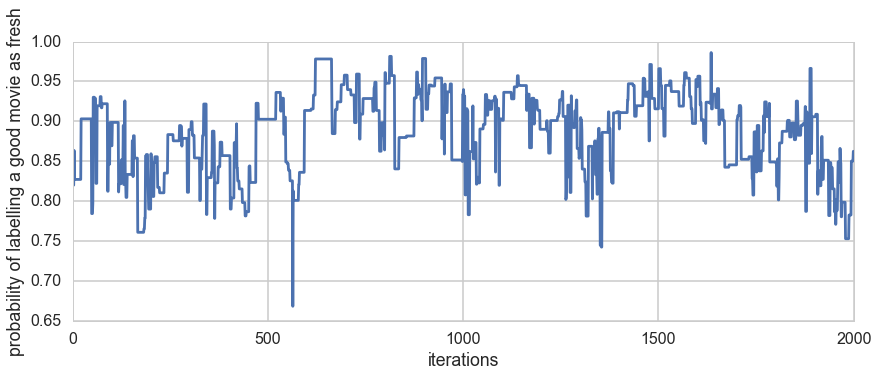

In [39]:
plt.figure(figsize=[14,5])
plt.plot(theta_fresh3)
plt.ylabel("probability of labelling a good movie as fresh")
plt.xlabel("iterations")

MAP for labelling a good movie as fresh:  0.911994340182


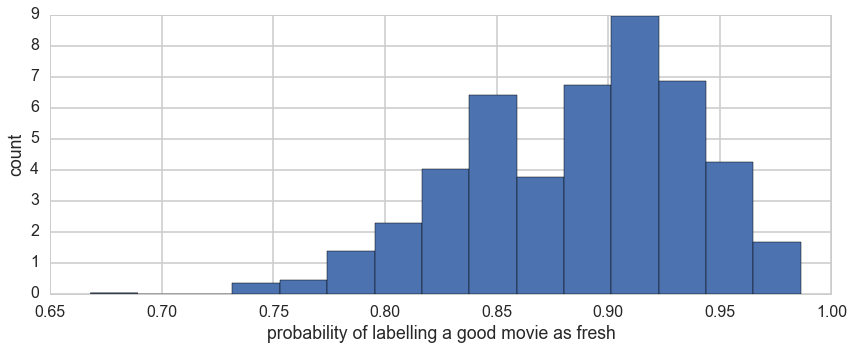

In [40]:
plt.figure(figsize=[14,5])
fresh_hist = plt.hist(theta_fresh3, bins=15, normed=True, label='confusion_fresh')
plt.xlabel("probability of labelling a good movie as fresh")
plt.ylabel("count")

# find the MAP
map_index_fresh = np.argmax(fresh_hist[0]) #index of the largest value in the histogram
hist_bin_middle_fresh = 0.5*fresh_hist[1][:-1] + 0.5*fresh_hist[1][1:] #value of the bin middle
fresh_map = hist_bin_middle_fresh[map_index_fresh]
print "MAP for labelling a good movie as fresh: ", fresh_map

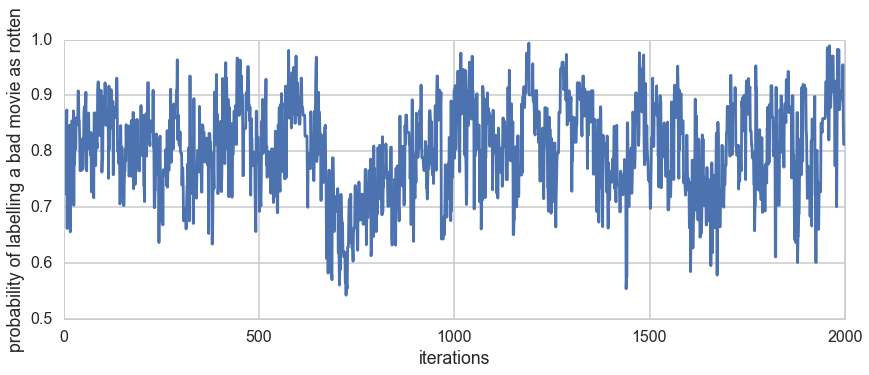

In [41]:
plt.figure(figsize=[14,5])
plt.plot(theta_rotten3)
plt.ylabel("probability of labelling a bad movie as rotten")
plt.xlabel("iterations")

MAP for labelling a bad movie as rotten:  0.871596985916


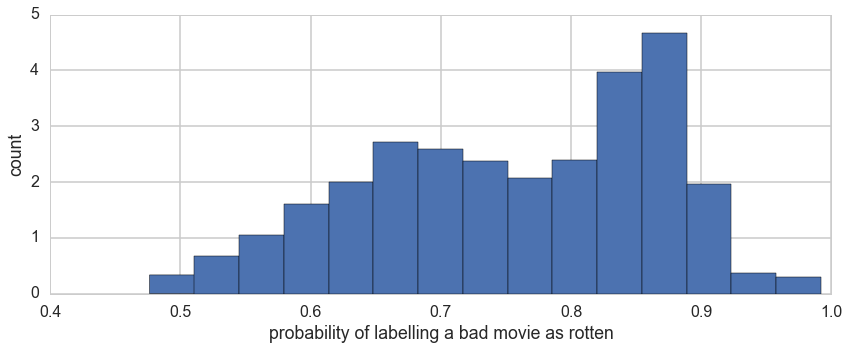

In [42]:
plt.figure(figsize=[14,5])
rotten_hist = plt.hist(theta_rotten2, bins=15, normed=True, label='confusion_rotten')
plt.xlabel("probability of labelling a bad movie as rotten")
plt.ylabel("count")

# find the MAP
map_index_rotten = np.argmax(rotten_hist[0]) #index of the largest value in the histogram
hist_bin_middle_rotten = 0.5*rotten_hist[1][:-1] + 0.5*rotten_hist[1][1:] #value of the bin middle
rotten_map = hist_bin_middle_rotten[map_index_rotten]
print "MAP for labelling a bad movie as rotten: ", rotten_map

In [94]:
# For each of the movies, count the number of upvotes and downvotes
num_movie = len(top_critics_rating)
upvotes = np.zeros(num_movie)
numvotes = np.zeros(num_movie)
i = 0
for key in top_critics_rating:
    numvotes[i] = len(top_critics_rating[key])
    for c in top_critics_rating[key]:
        upvotes[i] += c[1]
    i += 1

In [93]:
## Define function to calculate posterior

def posterior_pupvote(alphapara,betapara, numupvotes,numvotes, samples=100000):
    #The prior for the rate parameter
    priorpupvote = pm.Beta("priorpupvote", alphapara, betapara)
    @pm.deterministic 
    def pupvote(a=priorpupvote):
        return a
    #Likelihood function which incorporates our known data
    likelihood = pm.Binomial('likelihood', n=numvotes, p=pupvote, value=numupvotes, observed=True)
    #Create the Bayesian model for pymc
    popularity_model=pm.Model([priorpupvote, pupvote, likelihood])
    mcmc = pm.MCMC(popularity_model)     
    #Ask pymc to run the sampler, specifying the burn in to be discarded
    mcmc.sample(iter=samples, burn=samples / 4, thin=4)
    return mcmc

In [ ]:
# prior parameters:
alpha = 2
beta = 2

mean_pupvote = []

for movieindx in np.arange(num_movie):
    movie_mcmc = posterior_pupvote(alpha,beta,upvotes[movieindx],numvotes[movieindx])
    mean_pupvote.append(np.percentile(np.sort(movie_mcmc.trace('pupvote')[:]),50)) 

In [ ]:
truemovielabel = (np.asarray(mean_pupvote)>0.5).astype(int)
print 'movie labels based on all critics:', truemovielabel
print 'movie labels based on top critics:',(np.asarray(np.mean(top_ratings,1))>0.5).astype(int)
#print 'probability of upvote for the different movies',mean_pupvote
print 'percentage of good(p>0.5) movies:', np.sum(np.asarray(mean_pupvote)>0.5)*100/num_movie